In [84]:
from FwtModels import AssumedShapes
import numpy as np
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import y,x,t
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.linalg import eig

plt.style.use('seaborn')

### Lets Plot a Flapping Wing

It's time to just see if this thing works with a flapping wing

So we will take the parameters we have always been using but with a few changes

- inner wing now takes its weight from the bar (density of 8000kgm^-3)
- FWT takes up 29% of the wetted area
- TODO - Add a lumped mass to the end of the main wing (at 0.875m - 0.2Kg)
- FWT now has a uniform weight to equal a weight of 0.597Kg

In [85]:
semiSpan = 1.345  # semi-span of the wing
ratioFwt = 0.29   # ratio of the wing semi span that is fwt
chord = 0.15
FwtMassPerUnitArea = 0.597/(semiSpan*ratioFwt*chord)

In [86]:
# with width b and hieght h
h = 0.005 # hieght of bar
b = 0.03 # width of bar
I_xx = b*h**3/12
I_yy = b**3*h/12
J = I_xx + I_yy



# Material properties
E = 190e9
G = 74e9
Density = 8000

WingMassPerUnitArea = 8000*h*b/chord # convert to uniform mass over a chord 

In [87]:
# create an instance of the class holding all the properties for the FWT
p = AssumedShapes.FwtParameters(m_w = WingMassPerUnitArea,
                        m_t = FwtMassPerUnitArea,
                        x_f = 0.25,
                        s_w = semiSpan*(1-ratioFwt),
                        s_t = semiSpan*ratioFwt,
                        c = chord,
                        Lambda = np.deg2rad(10),
                        EI = E*I_xx,
                        GJ = G*J,
                        k_theta = 0,
                        rho = 1.225,
                        V = 10,
                        a_w = 2*np.pi,
                        a_t = 2*np.pi,
                        alpha_0 = 0,
                        e = 0.25,
                        Malphadot = -1.2,
                        g = 9.81)

In [90]:
# create generalised coordinates
q0,q1,q2,q3,q4 = me.dynamicsymbols('q:5')
q = sym.Matrix([q0,q1,q2,q3,q4])

## create model

# define shape Functions
z_w =q0*y**2+q1*y**3+q2*y*(x-p.x_f)+q3*y**2*(x-p.x_f)

alpha_w = q2*y+q3*y**2

# FWT is locked so is parrallel to the end of the main wing
z_t = z_w.subs(y,p.s_w) + y*q4
alpha_t = alpha_w.subs(y,p.s_w) + q4*sym.sin(p.Lambda)

# create the model
sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p,thetaIndex = 4)
sModel.GenerateEoM()

# create numeric Model (leaving V as an unknown)
variables = list(p.GetTuple())
variables.remove(p.V)

nModel = sModel.createNumericInstance(tuple(variables))

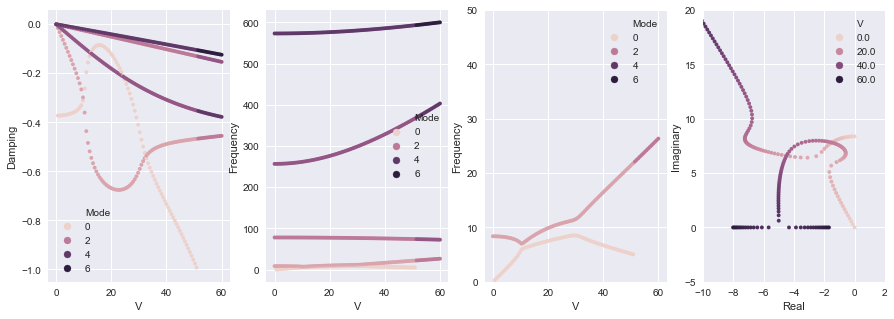

In [116]:
me.mechanics_printing()
Mp = sym.lambdify(p.V,nModel.MprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
Kp = sym.lambdify(p.V,nModel.KprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
V = np.linspace(0,60,100)
dps = []
for i in range(0,len(V)):
    evals,evecs = eig(Kp(V[i]),Mp(V[i]))
    _,ind = np.unique(np.round(np.abs(evals),4),return_index=True)
    evals = evals[ind]
    for j in range(0,len(evals)):
        m = evals[j]
        if np.imag(m)>0:
            dps.append([V[i],np.abs(m),np.cos(np.angle(m)),j,np.real(m),np.imag(m)])
        else:
            dps.append([V[i],0,0,j,np.real(m),0])

df = pd.DataFrame(data = dps,columns=['V','Frequency','Damping','Mode','Real','Imaginary'])

#only plot

f, axes = plt.subplots(1, 4,figsize=(15,5))
sns.scatterplot(x="V",y="Damping",hue="Mode",data=df[df['Frequency']>0],ax=axes[0],s = 15,linewidth=0)
sns.scatterplot(x="V",y="Frequency",hue="Mode",data=df[df['Frequency']>0],ax=axes[1],s = 15,linewidth=0)
sns.scatterplot(x="V",y="Frequency",hue="Mode",data=df[df['Frequency']>0],ax=axes[2],s = 15,linewidth=0)
sns.scatterplot(x="Real",y="Imaginary",hue="V",data=df,ax=axes[3],s = 15,linewidth=0)
axes[2].set(ylim=(0,50))
axes[3].set(ylim=(-5,20),xlim=(-10,2))
plt.show()

In [10]:
# TODO - plot some mode shapes

## what happens if you vary the mass of the FWT?

In [11]:
variables = list(p.GetTuple())
variables.remove(p.V)
variables.remove(p.m_t)
nModel = sModel.createNumericInstance(tuple(variables))

,0,1,2,3,4
621,0.000000+0.000000j,-0.000000-0.000305j,0.000000+0.000305j,0.000000-0.001539j,0.000000+0.001539j
622,0.000000+0.000000j,0.585251+0.000000j,0.585251-0.000000j,0.815196+0.000000j,0.815196-0.000000j
623,0.000000+0.000000j,0.174485+0.000000j,0.174485-0.000000j,0.394721+0.000000j,0.394721-0.000000j
624,1.000000+0.000000j,0.000000-0.000027j,0.000000+0.000027j,0.000000-0.000108j,0.000000+0.000108j
625,0.000000+0.000000j,0.000000+0.000375j,0.000000-0.000375j,0.000000+0.001234j,0.000000-0.001234j
1136,0.000000+0.000000j,-0.000000-0.000366j,0.000000+0.000366j,0.000000-0.002010j,0.000000+0.002010j
1137,0.000000+0.000000j,0.616067+0.000000j,0.616067-0.000000j,0.829150+0.000000j,0.829150-0.000000j
1138,0.000000+0.000000j,0.191902+0.000000j,0.191902-0.000000j,0.419923+0.000000j,0.419923-0.000000j
1139,1.000000+0.000000j,0.000000-0.000020j,0.000000+0.000020j,0.000000-0.000095j,0.000000+0.000095j
1140,0.000000+0.000000j,0.000000+0.000419j,0.000000-0.000419j,0.000000+0.001531j,0.000000-0.001531j


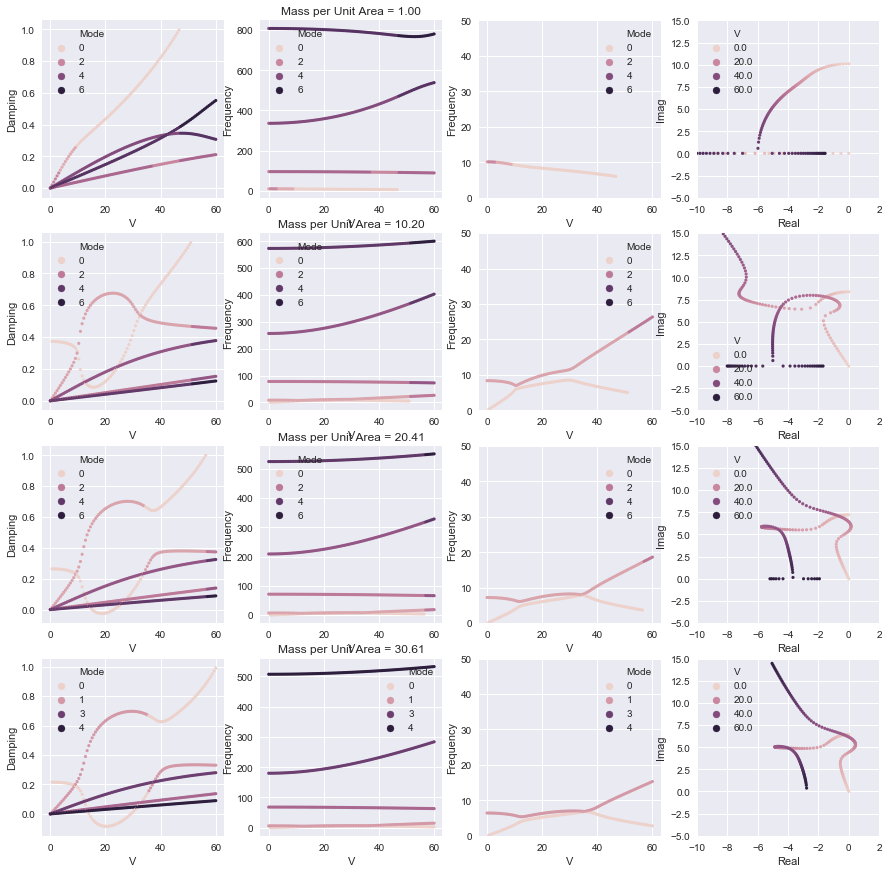

In [80]:
me.mechanics_printing()
Mp = sym.lambdify([p.V,p.m_t],nModel.MprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
Kp = sym.lambdify([p.V,p.m_t],nModel.KprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
V = np.linspace(0,60,100)
mass = np.arange(0,4)*FwtMassPerUnitArea
mass[mass==0]=1
dps = []
for k in range(0,len(mass)):
    for i in range(0,len(V)):
        evals,evecs = eig(Kp(V[i],mass[k]),Mp(V[i],mass[k]))
        _,ind = np.unique(np.round(np.abs(evals),4),return_index=True)
        evals = evals[ind]
        evecs = evecs[ind]
        for j in range(0,len(evals)):
            cN = evals[j]
            if np.imag((evals[j])) != 0:
                dps.append([V[i],mass[k],np.abs(cN),-np.cos(np.angle(cN)),np.real(cN),np.imag(cN),j,evecs[j]])
            else:
                dps.append([V[i],mass[k],np.NaN,np.NaN,np.real(cN),np.imag(cN),j,evecs[j]])
                
                    

df = pd.DataFrame(data = dps,columns=['V','Mass','Frequency','Damping','Real','Imag','Mode','Mode Shape'])


f, axes = plt.subplots(4, 4,figsize=(15,15))

for i in range(0,4):
    d = df[df['Mass']==mass[i]]
    sns.scatterplot(x="V",y="Damping",hue="Mode",data=d,ax=axes[i,0],s=10,linewidth=0)
    sns.scatterplot(x="V",y="Frequency",hue="Mode",data=d,ax=axes[i,1],s=10,linewidth=0).set_title(f'Mass per Unit Area = {mass[i]:.2f}')
    sns.scatterplot(x="V",y="Frequency",hue="Mode",data=d,ax=axes[i,2],s=10,linewidth=0)
    sns.scatterplot(x="Real",y="Imag",hue="V",data=d,ax=axes[i,3],s=10,linewidth=0)
    axes[i,2].set(ylim=(0,50))
    axes[i,3].set(ylim=(-5,15),xlim=(-10,2))
    
dff = (df[(df['Mass']>10) & (df['V']==0)])

dff['Mode Shape'].apply(lambda x :pd.Series(x[:int(len(x)/2)]))

# How do I plot some mode shapes?